Copyright © 2025 HQS Quantum Simulations GmbH. All Rights Reserved.

# Elecron spectroscopy: singlet-triplet splitting

Electron spectroscopy measures excited states of molecules. Depending on the setup, it can probe purely electronic excitations, vibrational structure on top of them, or their coupling. A particularly important quantity that these measurements access is the singlet–triplet energy splitting $ΔE_{ST}$ between the lowest singlet (S1) and triplet (T1) states. In this example we focus on accurately predicting  $ΔE_{ST}$ for realistic molecules.

In [1]:
# HQS packages
# Installation command: hqstage install hqs_spectrum_tools
from hqs_quantum_solver.spins import VectorSpace, Operator
from hqs_quantum_solver.spins import struqture_term
# Installation command: hqstage install hqs_electron_spectroscopy
from electron_spectroscopy import Hamiltonians

# Standard python packages
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

Take the Hamiltonian from the electron spectroscopy database.

In [2]:
ham = Hamiltonians.stored_hamiltonians["cyclopentadiene"]

Choose simulation parameters: number of spins in the bath (environment) gives you the number of qubits. More spins will support a more accurate model of the bath.

In [3]:
num_spins_bath = 4

Build and solve Hamiltonian with quantun solver

In [4]:
def build_and_solve(num_spins_bath, ham):
    num_spins_cas = 2
    # vector space for the active orbital (CAS) space
    v_cas = VectorSpace(sites=num_spins_cas, total_spin_z="all")
    # vector spaces for the bosonic bath for empty, single and double excitations in the bath
    v_bath_0 = VectorSpace(sites=num_spins_bath, total_spin_z=-num_spins_bath)
    v_bath_1 = VectorSpace(sites=num_spins_bath, total_spin_z=-num_spins_bath + 2)
    v_bath_2 = VectorSpace(sites=num_spins_bath, total_spin_z=-num_spins_bath + 4)
    v_bath_3 = VectorSpace(sites=num_spins_bath, total_spin_z=-num_spins_bath + 6)
    v_bath_4 = VectorSpace(sites=num_spins_bath, total_spin_z=-num_spins_bath + 8)
    #  Now build the complete vector space
    v_bath = v_bath_0 | v_bath_1 | v_bath_2 | v_bath_3 | v_bath_4  # | v_bath_5
    v = v_cas * v_bath
    # Convert struqture Hamiltonian directly to Quantum Solver operator
    trunc_H = ham.truncate_env(n_qubits=num_spins_bath, allow_large=False)
    H = Operator(struqture_term(trunc_H), domain=v)
    # Now solve as usual
    k = min(10, H.shape[0] - 1)
    eigenvalues, _ = eigsh(H, k=k, which="SA")

    return eigenvalues

Singlet triplet gap $\Delta E_{ST}$ is a difference between the ground state energy (singlet) and the first excited state energy (triplet).

In [6]:
print("Number of bath spins: Nq =", num_spins_bath)
eigenvalues = build_and_solve(num_spins_bath=num_spins_bath, ham=ham)
print("Singlet triplet gap:")
print("E_T-E_S =", (eigenvalues[1] - eigenvalues[0]) * 27.2114, "eV")

Number of bath spins: Nq = 4
Singlet triplet gap:
E_T-E_S = 3.394010755984684 eV


Observe how the computed energy gaps (splittings of the single-triplet states) converge with increased number of bath qubits compared to the reference value, known explicitly for this example.

In [7]:
ST_splittings = []
min_q = 4
max_q = 30
for n_qubits in range(min_q, max_q):
    eigenvalues = build_and_solve(num_spins_bath=n_qubits, ham=ham)
    ST_splittings.append(eigenvalues[1] - eigenvalues[0])

# Convert to eV
ST_splittings = np.array(ST_splittings) * 27.2114

Get the reference splitting value from quantum chemistry

In [8]:
from electron_spectroscopy.data_dict import excitation_energies

E_ref = excitation_energies["cyclopentadiene"][0].excitation_energies[0]
print("Reference splitting, eV = ", E_ref)

Reference splitting, eV =  3.326


Plot results

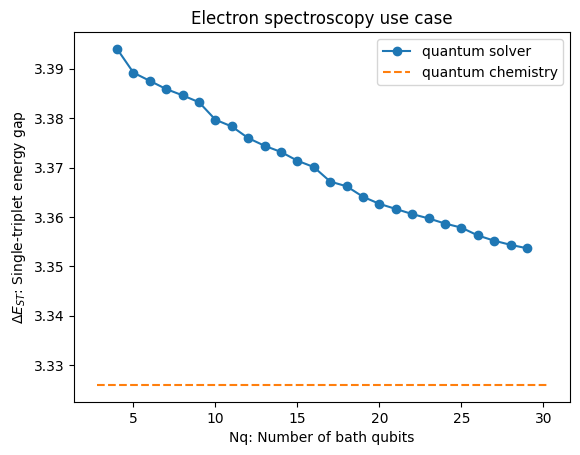

In [9]:
plt.plot(np.arange(min_q, max_q), ST_splittings, "-o", label="quantum solver")
x0, x1 = plt.xlim()
plt.plot([x0, x1], [E_ref, E_ref], "--", label="quantum chemistry")
plt.title("Electron spectroscopy use case")
plt.xlabel("Nq: Number of bath qubits")
plt.ylabel(r"$\Delta E_{ST}$: Single-triplet energy gap")
plt.legend();